In [1]:
from examples.cfd import plot_field, init_hat
import numpy as np
%matplotlib inline

# Some variable declarations
nx = 100
ny = 100
nt = 1000

nu = 0.15 #the value of base viscosity

offset = 1 # Used for field definition

visc =  np.full((nx, ny), nu) # Initialize viscosity
visc[nx//4-offset:nx//4+offset, 1:-1] = 0.0001 # Adding a material with different viscosity
visc[1:-1,nx//4-offset:nx//4+offset ] = 0.0001 
visc[3*nx//4-offset:3*nx//4+offset, 1:-1] = 0.0001 

visc_nb = visc[1:-1,1:-1]

dx = 2. / (nx - 1)
dy = 2. / (ny - 1)
sigma = .25
dt = sigma * dx * dy / nu


# Initialize our field

# Initialise u with hat function
u_init = np.empty((nx, ny))
init_hat(field=u_init, dx=dx, dy=dy, value=1)
u_init[10:-10, 10:-10] = 1.5


zmax = 2.5 # zmax for plotting

In [2]:
def diffuse(u, nt ,visc):
    for n in range(nt + 1): 
        un = u.copy()
        u[1:-1, 1:-1] = (un[1:-1,1:-1] + 
                        visc*dt / dy**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                        visc*dt / dx**2 * (un[2:,1: -1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))
        u[0, :] = 1
        u[-1, :] = 1
        u[:, 0] = 1
        u[:, -1] = 1

Initial state


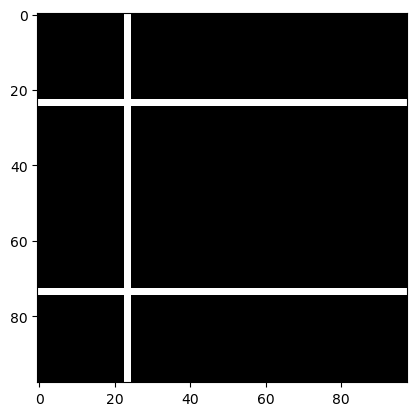

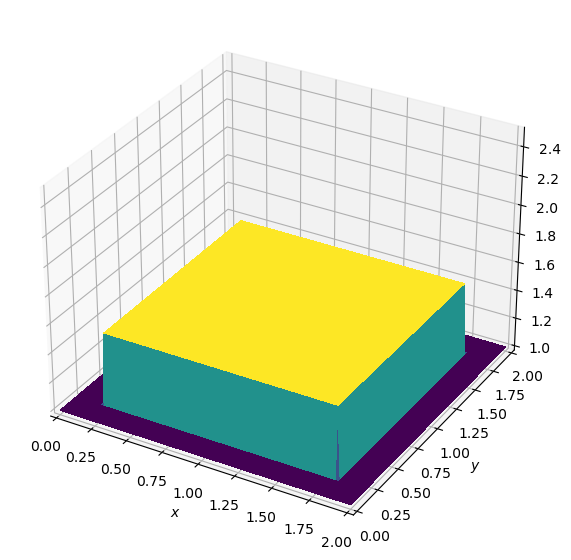

After 1000 timesteps


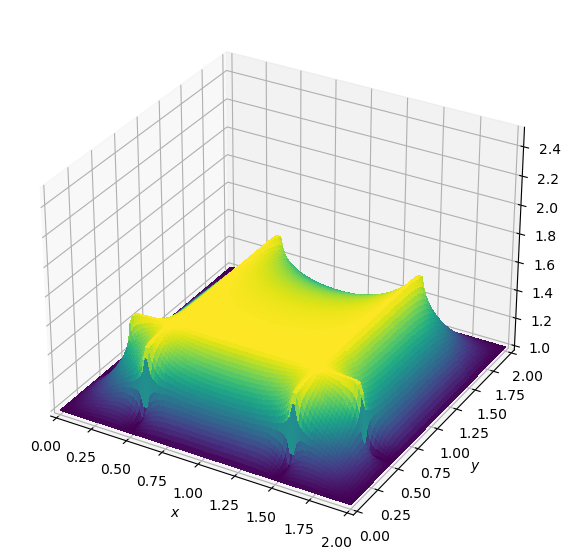

After another 1000 timesteps


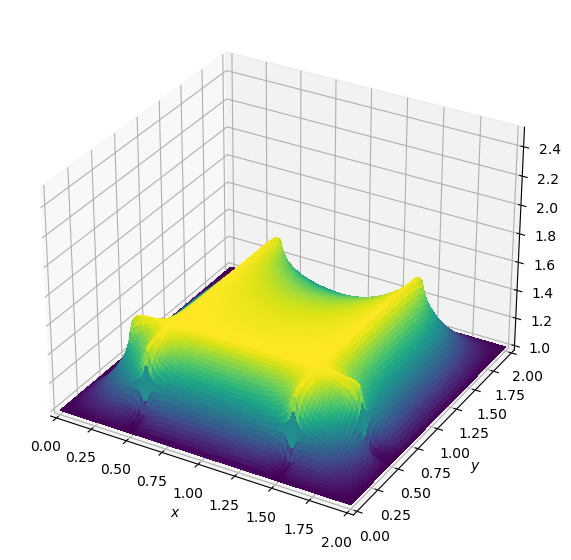

In [3]:
#NBVAL_IGNORE_OUTPUT

# Plot material according to viscosity, uncomment to plot
import matplotlib.pyplot as plt
plt.imshow(visc_nb, cmap='Greys',  interpolation='nearest')

# Field initialization
u = u_init

print ("Initial state")
plot_field(u, zmax=zmax)

diffuse(u, nt , visc_nb )
print ("After", nt, "timesteps")
plot_field(u, zmax=zmax)

diffuse(u, nt, visc_nb)
print ("After another", nt, "timesteps")
plot_field(u, zmax=zmax)

After 1000 timesteps


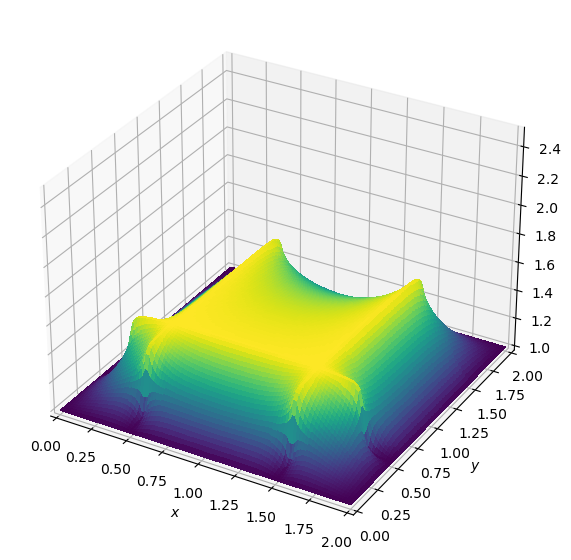

In [4]:
#NBVAL_IGNORE_OUTPUT

# Field initialization
u = u_init


diffuse(u, nt , visc_nb)
print ("After", nt, "timesteps")
plot_field(u, zmax=zmax)

In [5]:
from devito import Grid, TimeFunction, Eq, solve, Function
from sympy.abc import a
from sympy import nsimplify

# Initialize `u` for space order 2
grid = Grid(shape=(nx, ny), extent=(2., 2.))

# Create an operator with second-order derivatives
a = Function(name='a',grid = grid) # Define as Function
a.data[:]= visc  # Pass the viscosity in order to be used in the operator.



u = TimeFunction(name='u', grid=grid, space_order=2)

# Create an equation with second-order derivatives
eq = Eq(u.dt, a * u.laplace)
stencil = solve(eq, u.forward)
eq_stencil = Eq(u.forward, stencil)

print(nsimplify(eq_stencil))

Eq(u(t + dt, x, y), dt*((Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)))*a(x, y) + u(t, x, y)/dt))


Operator `Kernel` ran in 0.01 s


After 1000 timesteps


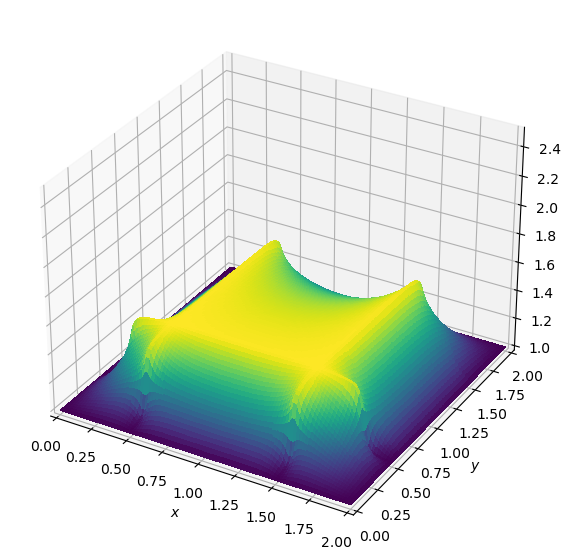

Operator `Kernel` ran in 0.01 s


After another 1000 timesteps


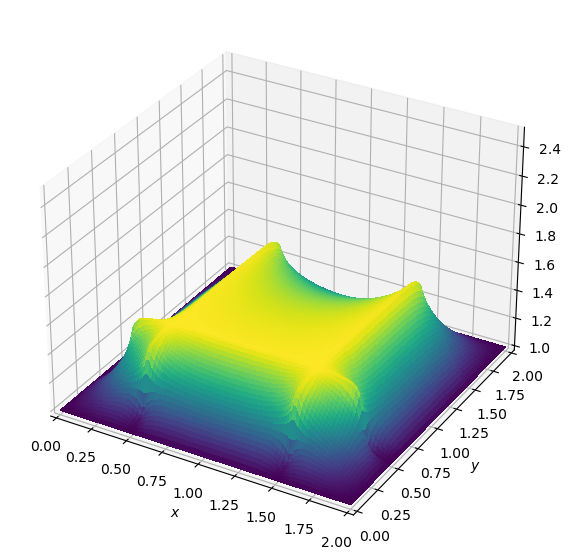

In [6]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator, Constant, Eq, solve, Function


# Reset our data field and ICs
init_hat(field=u.data[0], dx=dx, dy=dy, value=1.)

# Field initialization
u.data[0] = u_init


# Create an operator with second-order derivatives
a = Function(name='a',grid = grid)
a.data[:]= visc

eq = Eq(u.dt, a * u.laplace, subdomain=grid.interior)
stencil = solve(eq, u.forward)
eq_stencil = Eq(u.forward, stencil)

# Create boundary condition expressions
x, y = grid.dimensions
t = grid.stepping_dim
bc = [Eq(u[t+1, 0, y], 1.)]  # left
bc += [Eq(u[t+1, nx-1, y], 1.)]  # right
bc += [Eq(u[t+1, x, ny-1], 1.)]  # top
bc += [Eq(u[t+1, x, 0], 1.)]  # bottom


op = Operator([eq_stencil] + bc)
op(time=nt, dt=dt, a = a)

print ("After", nt, "timesteps")
plot_field(u.data[0], zmax=zmax)

op(time=nt, dt=dt, a = a)
print ("After another", nt, "timesteps")
plot_field(u.data[0], zmax=zmax)